In [1]:
import sys
sys.path.append('../')

import cii
import cii.datagen as dg
import cii.model as md
import cii.portfolio as pfo
import cii.strategy as stg
import pandas as pd

from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt

In [2]:
df_btc = pd.read_csv('..\data\coinapi_ohlcv_GEMINI_SPOT_BTC_USD_1DAY_data.csv')
df_eth = pd.read_csv('..\data\coinapi_ohlcv_GEMINI_SPOT_ETH_USD_1DAY_data.csv')

In [3]:
df_btc = dg.convert_coinapi_data(df_btc)
df_eth = dg.convert_coinapi_data(df_eth)
df_btc.head()

,price_close,price_open,price_high,price_low,time_close,time_open,trades_count,volume_traded
0,4591.38,4431.66,4705.07,4431.65,2017-08-30T00:00:00.0000000Z,2017-08-29T00:00:00.0000000Z,8315,6005.454508
1,4583.85,4590.00,4641.43,4495.05,2017-08-31T00:00:00.0000000Z,2017-08-30T00:00:00.0000000Z,14313,8832.814987
2,4736.28,4583.00,4762.76,4579.91,2017-09-01T00:00:00.0000000Z,2017-08-31T00:00:00.0000000Z,11407,7268.196353
3,4924.00,4736.28,4924.00,4709.28,2017-09-02T00:00:00.0000000Z,2017-09-01T00:00:00.0000000Z,11470,8188.879244
4,4642.85,4924.00,4985.00,4505.00,2017-09-03T00:00:00.0000000Z,2017-09-02T00:00:00.0000000Z,20976,13402.051241


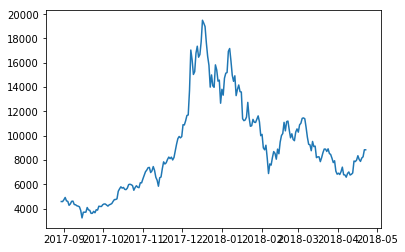

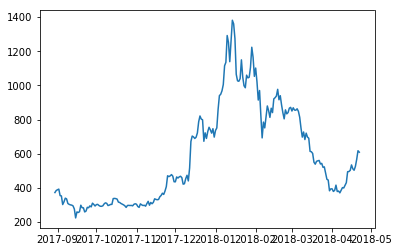

corr is {-5: 0.13524173253654248, -4: -0.068317727701781877, -3: -0.0023798184791702583, -2: 0.055124328490755999, -1: 0.0013159118880296883, 0: 0.62918438629114393, 1: -0.098336503518480903, 2: 0.020717918547543599, 3: 0.099814409639165561, 4: -0.10633027857484348}


In [4]:
model_config = {'asset_type': 'spot'}
model_btc = md.AssetModelComponent('btc', df_btc, model_config)
model_eth = md.AssetModelComponent('eth', df_eth, model_config)
model_btc.plot_price()
model_eth.plot_price()
asset_model = md.AssetModel([])
asset_model.insert_component(model_btc)
asset_model.insert_component(model_eth)
price_btc_eth = asset_model.concat_prices('btc','eth')
logret_btc_eth = asset_model.concat_log_return('btc','eth', '1d')
print('corr is', asset_model.corr_log_return('btc', 'eth', '1d'))

In [5]:
class StrategyTest1(stg.Strategy):
    def apply_event_logic(self, time, prtf):
        btc = 'btc'
        eth = 'eth'
        if self.asset_model.has_component(btc) and self.asset_model.has_component(eth):
            prev_time = time - timedelta(days=1)
            
            comp_btc = self.asset_model.get_component(btc)
            ind_btc = comp_btc.bear_or_bull(time, self.rules)
            int_btc_prev = comp_btc.bear_or_bull(prev_time, self.rules)
            price_btc = comp_btc.get_price(time)

            comp_eth = self.asset_model.get_component(eth)
            ind_eth = comp_eth.bear_or_bull(time, self.rules)
            int_eth_prev = comp_eth.bear_or_bull(prev_time, self.rules)
            price_eth = comp_eth.get_price(time)

            if ind_btc == 1 and ind_eth == 1:
                prtf.buy(btc, price_btc, 0.5)
                prtf.buy(eth, price_eth, prtf.cash)
            elif ind_btc == 1 and ind_eth == 0:
                prtf.buy(btc, price_btc, 1.0)
            elif ind_btc == 1 and ind_eth == -1:
                prtf.sell_unit(eth, price_eth)
                prtf.buy(btc, price_btc, 0.25)
            elif ind_btc == -1:
                prtf.sell_unit(btc, price_btc)
                prtf.sell_unit(eth, price_eth)

#             print(ind_btc, ind_eth)
            if prtf.value(asset_model.get_prices(time)) > 1.1 * self.initial_portfolio.value(asset_model.get_prices(time)):
                prtf.set_aside(0.05 * prtf.value(asset_model.get_prices(time)))
#                 print(prtf.value(asset_model.get_prices(time)))
#                 print(self.initial_portfolio.value(asset_model.get_prices(time)))
#                 print('Give it to me!' )
#                 print(time)
                
        return prtf

In [6]:
cash = 100000
assets = {'btc': 0, 'eth': 0}
ini_pfo = pfo.Portfolio(assets, cash)
bb_rule = {'method' : 'moving_average', 'window_size' : [3], 'tolerance_up' : 0.01, 'tolerance_down' : 0.01}
strats = StrategyTest1(asset_model, ini_pfo, bb_rule)
start_date_str = '2018-02-01'
start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
report = strats.back_testing(start_date)
# print(report)

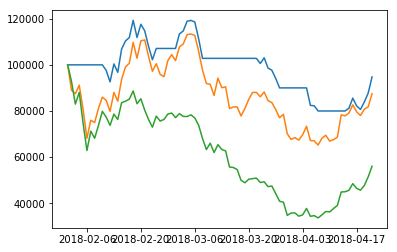

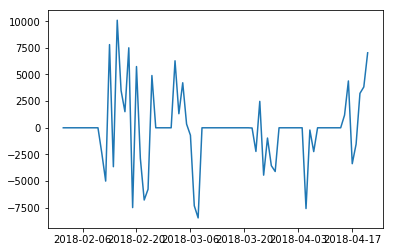

In [7]:
plt.plot(report['date'], report['total'])
plt.plot(report['date'], report['btc_price'] * cash / report['btc_price'][0])
plt.plot(report['date'], report['eth_price'] * cash / report['eth_price'][0])
plt.show()
plt.plot(report['date'], report['pnl'])
plt.show()

In [8]:
class StrategyTest2(stg.Strategy):
    def apply_event_logic(self, time, prtf):
        btc = 'btc'
        if self.asset_model.has_component(btc):
            comp_btc = self.asset_model.get_component(btc)
            ind_btc = comp_btc.average_comparison(time, self.rules)
            price_btc = comp_btc.get_price(time)

            if ind_btc == -1:
                prtf.sell_unit(btc, price_btc)
            elif ind_btc == 1:
                prtf.buy(btc, price_btc, 1)     
            else:
                pass

        return prtf

In [9]:
cash = 100000
assets = {'btc': 0}
ini_pfo = pfo.Portfolio(assets, cash)
bb_rule = {'method' : 'moving_average', 'window_size' : [1, 5], 'tolerance_up' : 0.005, 'tolerance_down' : 0}
strats = StrategyTest1(asset_model, ini_pfo, bb_rule)
start_date_str = '2018-01-01'
start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
report = strats.back_testing(start_date)

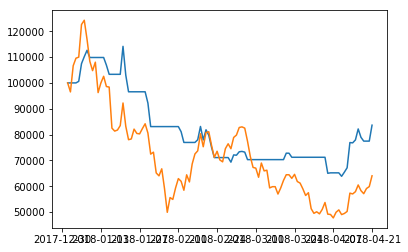

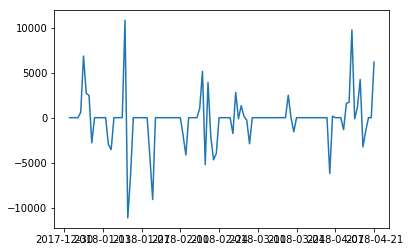

In [10]:
plt.plot(report['date'], report['total'])
plt.plot(report['date'], report['btc_price'] * cash / report['btc_price'][0])
plt.show()
plt.plot(report['date'], report['pnl'])
plt.show()

In [11]:
class StrategyTest3(stg.Strategy):
    def apply_event_logic(self, time, prtf):
        btc = 'btc'
        eth = 'eth'
        if self.asset_model.has_component(btc) and self.asset_model.has_component(eth):
            p_time = time - timedelta(days=3)
            pp_time = time - timedelta(days=6)
            
            comp_btc = self.asset_model.get_component(btc)
#            ind_btc = comp_btc.bear_or_bull(time, self.rules)
#             ind_btc_after = comp_btc.bear_or_bull(after_time, self.rules)
            price_btc = comp_btc.get_price(time)
            price_btc_p = comp_btc.get_price(p_time)
            price_btc_pp = comp_btc.get_price(pp_time)
            
            cvx = (price_btc - price_btc_p) - (price_btc_p - price_btc_pp)
#             comp_eth = self.asset_model.get_component(eth)
#             ind_eth = comp_eth.bear_or_bull(time, self.rules)
#             ind_eth_prev = comp_eth.bear_or_bull(prev_time, self.rules)
#             price_eth = comp_eth.get_price(time)

#             if ind_btc_prev == -1 and ind_btc == 1:
#                 prtf.buy(btc, price_btc, 1.0)
#             elif ind_btc_prev == -1 and ind_btc == 0:
#                 prtf.buy(btc, price_btc, 0.2)
#             elif ind_btc_prev == 1 and ind_btc != 1:
#                 prtf.sell(btc, price_btc, 0.8)
#             elif ind_btc_prev == 1 and ind_btc == 1:
#                 prtf.buy(btc, price_btc, 0.5)

            if cvx > 0:
                prtf.buy(btc, price_btc, 1.0)
            else:
                prtf.sell(btc, price_btc, 1.0)

#             if prtf.value(asset_model.get_prices(time)) > 1.1 * self.initial_portfolio.value(asset_model.get_prices(time)):
#                 prtf.set_aside(0.05 * prtf.value(asset_model.get_prices(time)))
#                 print(prtf.value(asset_model.get_prices(time)))
#                 print(self.initial_portfolio.value(asset_model.get_prices(time)))
#                 print('Give it to me!' )
#                 print(time)
                
        return prtf
    
cash = 100000
assets = {'btc': 0, 'eth': 0}
ini_pfo = pfo.Portfolio(assets, cash)
bb_rule = {'method' : 'moving_average', 'window_size' : [1], 'tolerance_up' : 0.0, 'tolerance_down' : 0.0}
strats = StrategyTest3(asset_model, ini_pfo, bb_rule)
start_date_str = '2018-02-01'
start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
report = strats.back_testing(start_date)
print(report)

         date          total           pnl           cash  set_aside  \
0  2018-02-01  100000.000000  0.000000e+00  100000.000000        0.0   
1  2018-02-02  100000.000000  0.000000e+00  100000.000000        0.0   
2  2018-02-03  100000.000000 -1.455192e-11       0.000000        0.0   
3  2018-02-04  104251.747018  4.251747e+03       0.000000        0.0   
4  2018-02-05   92288.020332 -1.196373e+04       0.000000        0.0   
5  2018-02-06   77926.686844 -1.436133e+04   77926.686844        0.0   
6  2018-02-07   77926.686844  0.000000e+00   77926.686844        0.0   
7  2018-02-08   77926.686844  0.000000e+00       0.000000        0.0   
8  2018-02-09   84269.953436  6.343267e+03       0.000000        0.0   
9  2018-02-10   89385.550683  5.115597e+03       0.000000        0.0   
10 2018-02-11   87902.810575 -1.482740e+03       0.000000        0.0   
11 2018-02-12   82974.045982 -4.928765e+03   82974.045982        0.0   
12 2018-02-13   82974.045982  0.000000e+00   82974.045982       

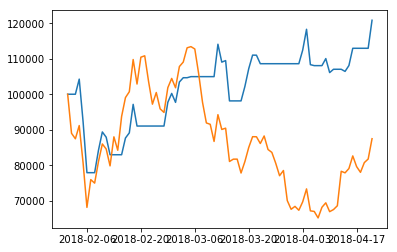

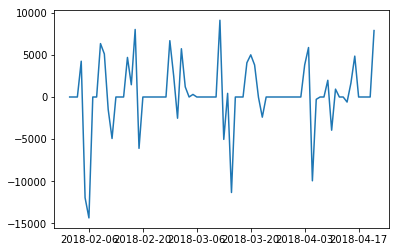

In [12]:
plt.plot(report['date'], report['total'])
plt.plot(report['date'], report['btc_price'] * cash / report['btc_price'][0])
plt.show()
plt.plot(report['date'], report['pnl'])
plt.show()

In [55]:
class StrategyTest3(stg.Strategy):
    def apply_event_logic(self, time, prtf):
        btc = 'btc'
        eth = 'eth'
        if self.asset_model.has_component(btc) and self.asset_model.has_component(eth):            
            comp_btc = self.asset_model.get_component(btc)
            ind_btc = comp_btc.double_dip(time, self.rules)
            price_btc = comp_btc.get_price(time)
            
            if ind_btc == 1:
                prtf.buy(btc, price_btc)
            else:
                prtf.sell(btc, price_btc)
 
            comp_eth = self.asset_model.get_component(eth)
            ind_eth = comp_eth.double_dip(time, self.rules)
            price_eth = comp_eth.get_price(time)
            
            if ind_btc == 1:
                prtf.buy(btc, price_btc, 1.0)
            elif ind_btc == -1:
                prtf.sell(btc, price_btc)
 
#             if ind_eth == 1:
#                 prtf.buy(eth, price_eth)
#             else:
#                 prtf.sell(eth, price_eth)
#             if prtf.value(asset_model.get_prices(time)) > 1.1 * self.initial_portfolio.value(asset_model.get_prices(time)):
#                 prtf.set_aside(0.05 * prtf.value(asset_model.get_prices(time)))
            
        return prtf
    
cash = 100000
assets = {'btc': 0, 'eth': 0}
ini_pfo = pfo.Portfolio(assets, cash)
bb_rule = {'method' : 'moving_average', 'window_size' : [7, 20], 'tolerance_up' : 0.0, 'tolerance_down' : 0.0}
strats = StrategyTest3(asset_model, ini_pfo, bb_rule)
start_date_str = '2018-01-01'
start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
report = strats.back_testing(start_date)

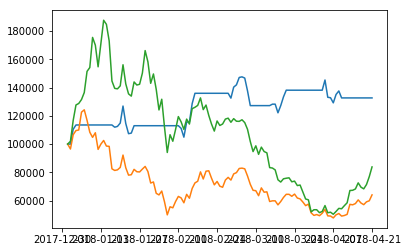

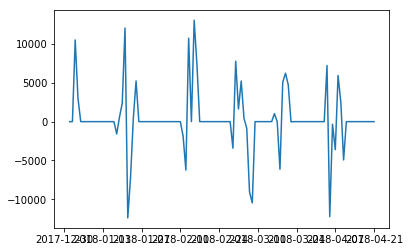

In [56]:
plt.plot(report['date'], report['total'])
plt.plot(report['date'], report['btc_price'] * cash / report['btc_price'][0])
plt.plot(report['date'], report['eth_price'] * cash / report['eth_price'][0])
plt.show()
plt.plot(report['date'], report['pnl'])
plt.show()